In [2]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' # default is ‘last_expr’

%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
from random import shuffle
import math
from shapely import wkt

import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter, defaultdict
import numpy as np

# Class distribution and splitting into train/val/test

This notebook tallies the distribution of the damage and background classes.

## Look at a label JSON

Examine one JSON file in the `labels` folder...

In [87]:
label_path = '../../data/challenge_data/train/labels/hurricane-matthew_00000000_post_disaster.json'

In [88]:
with open(label_path) as f:
    label_json = json.load(f)

In [89]:
label_json.keys()

dict_keys(['features', 'metadata'])

In [90]:
label_json['features'].keys()

dict_keys(['lng_lat', 'xy'])

In [91]:
label_json['metadata'].keys()

dict_keys(['sensor', 'provider_asset_type', 'gsd', 'capture_date', 'off_nadir_angle', 'pan_resolution', 'sun_azimuth', 'sun_elevation', 'target_azimuth', 'disaster', 'disaster_type', 'catalog_id', 'original_width', 'original_height', 'width', 'height', 'id', 'img_name'])

In [92]:
label_json['features']['xy'][0]

{'properties': {'feature_type': 'building',
  'subtype': 'minor-damage',
  'uid': '6dd06e25-353d-4ca2-8a93-bbdd44b10435'},
 'wkt': 'POLYGON ((184.3848180327538 1022.977380861319, 184.4809847188476 1015.871163903935, 203.263854348678 1016.01783797561, 203.5772080801356 1022.977565618902, 184.3848180327538 1022.977380861319))'}

In [93]:
feat_shape = wkt.loads(label_json['features']['xy'][0]['wkt'])

In [94]:
feat_shape.area

133.53150074518555

In [95]:
total_area = 0

for feat in label_json['features']['xy']:
    feat_shape = wkt.loads(feat['wkt'])
    total_area += feat_shape.area

total_area  # this looks about right from visualizing this tile's mask - it's < 200*200 squared pixels

25928.990821215957

## Aggregate building counts and area

Example file names
```
joplin-tornado_00000004_post_disaster.json
joplin-tornado_00000004_pre_disaster.json
```

`subtypes` are:
```
{'destroyed', 'major-damage', 'minor-damage', 'no-damage', 'un-classified'}
```

There are some features without a `sub-types` field. 

In [96]:
label_dirs = [
    '../../data/challenge_data/train/labels',
    '../../data/challenge_data//test/labels',
    '../../data/challenge_data/hold/labels',
    '../../data/challenge_data/tier3/labels'
]

In [97]:
# area breakdown by disaster
pre_areas = defaultdict(lambda: defaultdict(float))
post_areas = defaultdict(lambda: defaultdict(float))

# count of building features
pre_counts = defaultdict(lambda: defaultdict(int))
post_counts = defaultdict(lambda: defaultdict(int))

feature_types = set()

# building features without a subtype attribute
buildings_no_type = []

for label_dir in label_dirs:
    for p in tqdm(os.listdir(label_dir)):
        
        if not p.endswith('.json'):
            continue
            
        areas_dict = pre_areas if p.endswith('pre_disaster.json') else post_areas
        counts_dict = pre_counts if p.endswith('pre_disaster.json') else post_counts
        
        with open(os.path.join(label_dir, p)) as f:
            label_json = json.load(f)
            
            disaster_name = label_json['metadata']['disaster']
            
            for feat in label_json['features']['xy']:
                
                if feat['properties']['feature_type'] != 'building':
                    feature_types.add(feat['properties']['feature_type'])
                    continue
                
                if 'subtype' in feat['properties']:
                    damage_class = feat['properties']['subtype']
                else:
                    damage_class = 'no-subtype'  # usually for pre images
                    buildings_no_type.append((p, feat))    
                    
                feat_shape = wkt.loads(feat['wkt'])
                
                areas_dict[disaster_name][damage_class] += feat_shape.area
                
                counts_dict[disaster_name][damage_class] += 1

100%|██████████| 12738/12738 [00:22<00:00, 568.82it/s] 


In [98]:
len(buildings_no_type)

425368

In [99]:
len(post_areas)

19

In [100]:
post_areas.keys()

dict_keys(['guatemala-volcano', 'hurricane-florence', 'hurricane-harvey', 'hurricane-matthew', 'hurricane-michael', 'mexico-earthquake', 'midwest-flooding', 'palu-tsunami', 'santa-rosa-wildfire', 'socal-fire', 'joplin-tornado', 'lower-puna-volcano', 'moore-tornado', 'nepal-flooding', 'pinery-bushfire', 'portugal-wildfire', 'sunda-tsunami', 'tuscaloosa-tornado', 'woolsey-fire'])

In [101]:
areas_and_counts_by_disaster = {
    'pre_areas': pre_areas,
    'post_areas': post_areas,
    'pre_counts': pre_counts,
    'post_counts': post_counts
}

In [102]:
with open('areas_and_counts_by_disaster.json', 'w') as f:
    json.dump(areas_and_counts_by_disaster, f, indent=4)

In [103]:
wind_disasters = ['hurricane-matthew', 'tuscaloosa-tornado', 'hurricane-michael', 'moore-tornado', 'joplin-tornado']

damage_classes = ['no-damage', 'minor-damage', 'major-damage', 'destroyed', 'un-classified']

In [104]:
# store data in dic as {disaster_name: [counts]}
wind_post_counts = defaultdict(list)  
wind_post_areas = defaultdict(list) 

for disaster in wind_disasters:
    for damage_class in damage_classes:
        wind_post_counts[disaster].append(post_counts[disaster][damage_class])
        wind_post_areas[disaster].append(post_areas[disaster][damage_class])

In [105]:
post_counts['moore-tornado']

defaultdict(int,
            {'no-damage': 19453,
             'un-classified': 586,
             'destroyed': 1584,
             'minor-damage': 886,
             'major-damage': 449})

In [106]:
wind_post_counts

defaultdict(list,
            {'hurricane-matthew': [4058, 12331, 2717, 3524, 1334],
             'tuscaloosa-tornado': [10499, 2036, 466, 1097, 908],
             'hurricane-michael': [22692, 8292, 2919, 1225, 373],
             'moore-tornado': [19453, 886, 449, 1584, 586],
             'joplin-tornado': [8225, 2192, 1005, 3274, 656]})

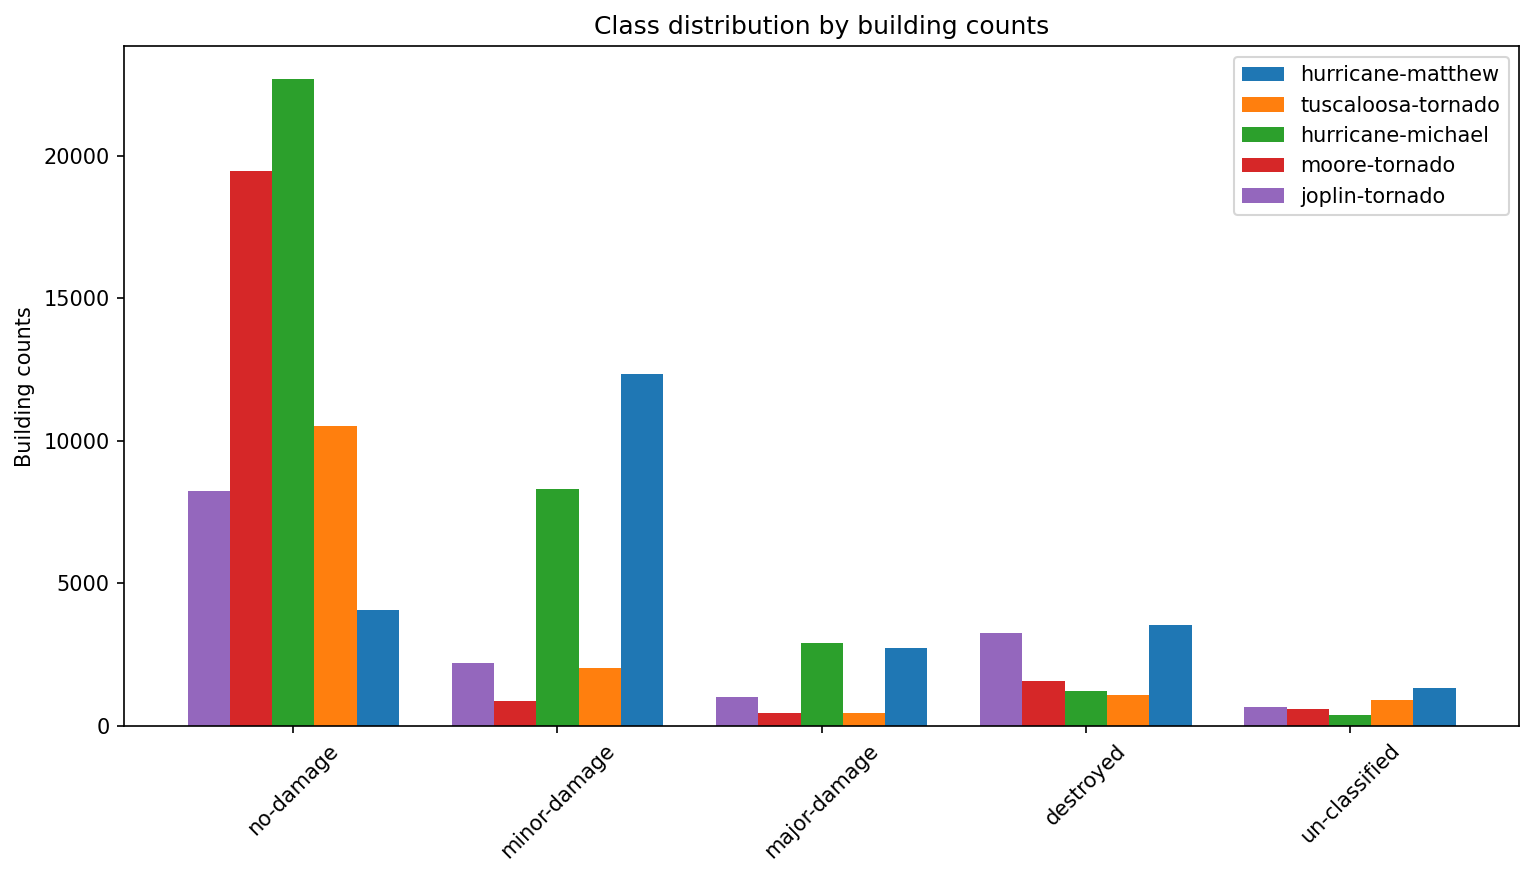

In [107]:
# Reference: https://matplotlib.org/3.3.1/gallery/lines_bars_and_markers/barchart.html
num_classes = len(damage_classes)

x = np.arange(num_classes)  # the label locations
width = 0.8/num_classes  # the width of the bars

fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=150)

for i, (disaster, li) in enumerate(wind_post_counts.items()):
    rect = ax.bar(x - (i - 2) * width, li, width, label=disaster)

_ = ax.set_ylabel('Building counts')
_ = ax.set_title('Class distribution by building counts')
_ = ax.set_xticks(x)
x_labels = ax.set_xticklabels(damage_classes, rotation=45)
_ = ax.legend()

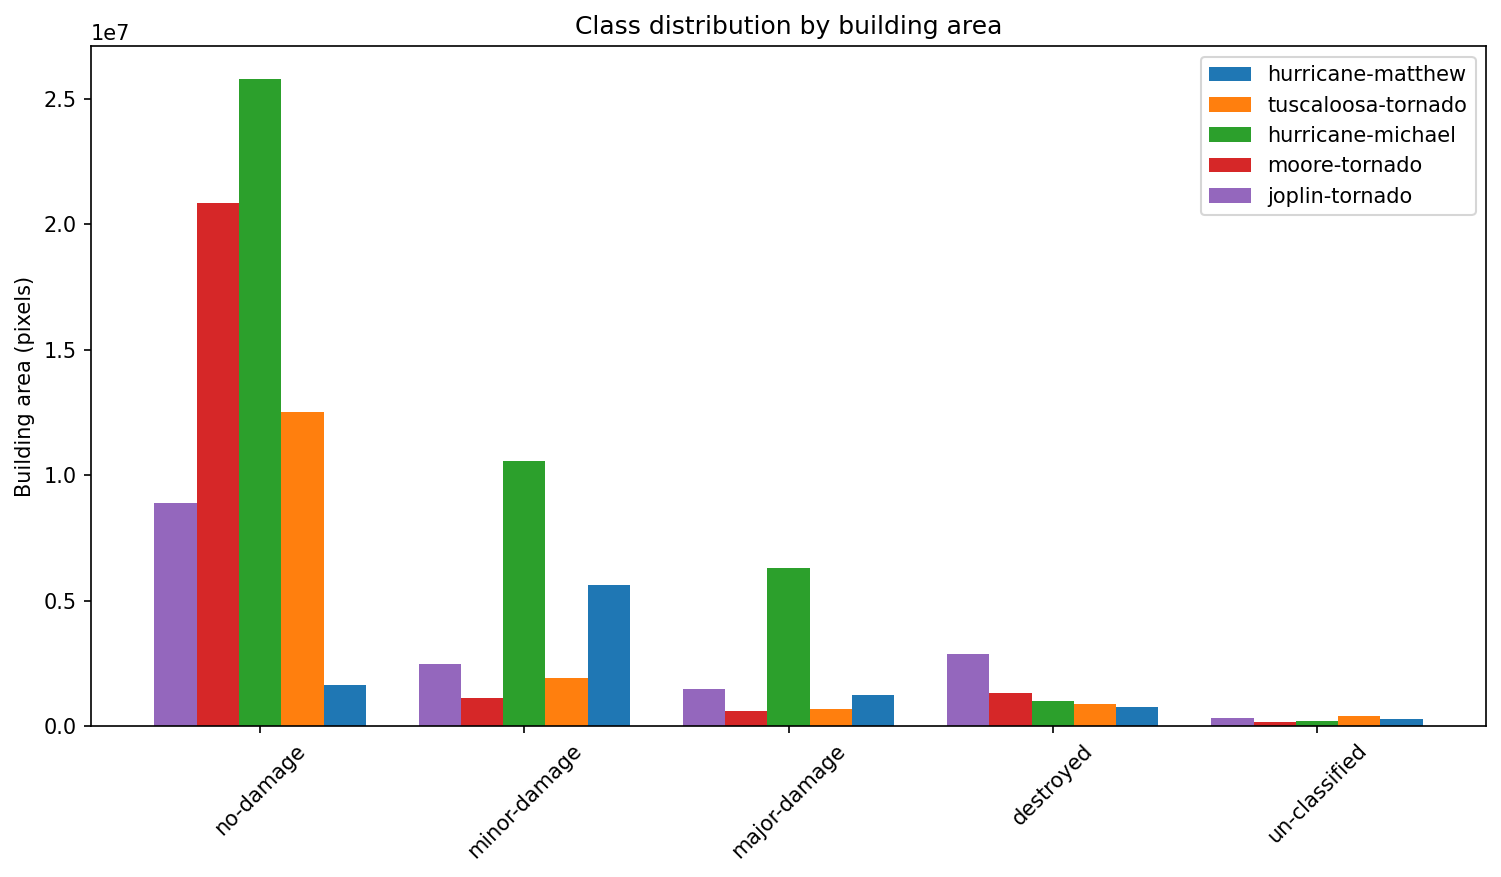

In [108]:
num_classes = len(damage_classes)

x = np.arange(num_classes)  # the label locations
width = 0.8/num_classes  # the width of the bars

fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=150)

for i, (disaster, li) in enumerate(wind_post_areas.items()):
    rect = ax.bar(x - (i - 2) * width, li, width, label=disaster)

_ = ax.set_ylabel('Building area (pixels)')
_ = ax.set_title('Class distribution by building area')
_ = ax.set_xticks(x)
x_labels = ax.set_xticklabels(damage_classes, rotation=45)
_ = ax.legend()

## Splitting into train/val/test - wind disasters

We do not use the splits released by the xView2 competition.

We split at the tile level (1024 by 1024 pixels), not at the chip level. 

In [109]:
%%time

xbd_root = '../../data/'
wind_disasters = ['hurricane-matthew', 'tuscaloosa-tornado', 'hurricane-michael', 'moore-tornado', 'joplin-tornado']
label_dirs = [
    '../../data/challenge_data/train/labels',
    '../../data/challenge_data//test/labels',
    '../../data/challenge_data/hold/labels',
    '../../data/challenge_data/tier3/labels'
]
all_files = defaultdict(list)  # wind disaster to list of files (no extension)

wind_disasters_tup = tuple(wind_disasters)

for label_dir in label_dirs:
    for p in tqdm(os.listdir(label_dir)):
        
        if not p.startswith(wind_disasters_tup):
            continue
        
        if not p.endswith('_post_disaster.json'):
            continue
        
        full_path = os.path.join(label_dir, p)
        rel_path = full_path.split(xbd_root)[1]
        
        # example: hurricane-matthew_00000000_post_disaster.json
        disaster_name = p.split('_')[0]
        file = rel_path.split('_post_disaster.json')[0]
        
        all_files[disaster_name].append(file)

100%|██████████| 12738/12738 [00:00<00:00, 382413.89it/s]

Wall time: 121 ms


In [110]:
for disaster_name, files in all_files.items():
    print(f'{disaster_name}, {len(files)}')

hurricane-matthew, 405
hurricane-michael, 550
joplin-tornado, 149
moore-tornado, 227
tuscaloosa-tornado, 343


In [111]:
# split randomly

wind_splits = defaultdict(dict)  # wind disaster to train/val/test

for disaster_name, files in all_files.items():
    shuffle(files)
    
    num_train_tiles = math.ceil(0.8 * len(files))
    num_val_tiles = math.ceil(0.1 * len(files))
    
    wind_splits[disaster_name]['train'] = sorted(files[:num_train_tiles])
    wind_splits[disaster_name]['val'] = sorted(files[num_train_tiles:num_train_tiles + num_val_tiles])
    wind_splits[disaster_name]['test'] = sorted(files[num_train_tiles + num_val_tiles:])
    
    print(f"{disaster_name}, train {len(wind_splits[disaster_name]['train'])}, val {len(wind_splits[disaster_name]['val'])}, test {len(wind_splits[disaster_name]['test'])}")

hurricane-matthew, train 324, val 41, test 40
hurricane-michael, train 440, val 55, test 55
joplin-tornado, train 120, val 15, test 14
moore-tornado, train 182, val 23, test 22
tuscaloosa-tornado, train 275, val 35, test 33


In [112]:
with open('../constants/splits/wind_disaster_splits.json', 'w') as f:
    json.dump(wind_splits, f, indent=4)

## Splitting into train/val/test - LOO subset disasters

In [122]:
%%time

xbd_root = '../../data/'

wind_disasters = ['hurricane-matthew', 'tuscaloosa-tornado', 'hurricane-michael', 'moore-tornado', 'joplin-tornado']

flood_disasters = ['midwest-flooding', 'nepal-flooding'] + ['hurricane-harvey', 'hurricane-florence']

earthquake_disasters = ['mexico-earthquake', 'palu-tsunami', 'sunda-tsunami']

others = ['guatemala-volcano', 'lower-puna-volcano', 'socal-fire', 'santa-rosa-wildfire','pinery-bushfire', 'portugal-wildfire', 'woolsey-fire']

subset_disasters = flood_disasters
label_dirs = [
    xbd_root + 'challenge_data/train/labels',
    xbd_root + 'challenge_data/test/labels',
    xbd_root + 'challenge_data/hold/labels',
    xbd_root + 'challenge_data/tier3/labels'
]
all_files = defaultdict(list)  # subset disaster to list of files (no extension)

subset_disasters_tup = tuple(subset_disasters)

for label_dir in label_dirs:
    for p in tqdm(os.listdir(label_dir)):
        
        if not p.startswith(subset_disasters_tup):
            continue
        
        if not p.endswith('_post_disaster.json'):
            continue
        
        #full_path = os.path.join(label_dir, p)
        full_path = label_dir+"/"+p
        rel_path = full_path.split(xbd_root)[1]
        
        # example: hurricane-matthew_00000000_post_disaster.json
        disaster_name = p.split('_')[0]
        file = rel_path.split('_post_disaster.json')[0]
        
        all_files[disaster_name].append(file)

100%|██████████| 12738/12738 [00:00<00:00, 636817.10it/s]

Wall time: 84 ms


In [114]:
for disaster_name, files in all_files.items():
    print(f'{disaster_name}, {len(files)}')

hurricane-florence, 546
hurricane-harvey, 522
midwest-flooding, 445
nepal-flooding, 619


In [125]:
# split leave one disaster out
disaster_to_leave_out = 'nepal-flooding' #'nepal-flooding' # 'joplin-tornado'

subset_splits = defaultdict(dict)  # subset disaster to train/val/test

for disaster_name, files in all_files.items():
    
    if disaster_name == disaster_to_leave_out:
        subset_splits[disaster_name]['train'] = []
        subset_splits[disaster_name]['val'] = []
        subset_splits[disaster_name]['test'] = files

    else:
        shuffle(files)
        num_train_tiles = math.ceil(0.8 * len(files))
        num_val_tiles = math.ceil(0.2 * len(files))
        subset_splits[disaster_name]['train'] = sorted(files[:num_train_tiles])
        subset_splits[disaster_name]['val'] = sorted(files[num_train_tiles:num_train_tiles + num_val_tiles])
        subset_splits[disaster_name]['test'] = []
    
    print(f"{disaster_name}, train {len(subset_splits[disaster_name]['train'])}, val {len(subset_splits[disaster_name]['val'])}, test {len(subset_splits[disaster_name]['test'])}")

hurricane-florence, train 437, val 109, test 0
hurricane-harvey, train 418, val 104, test 0
midwest-flooding, train 356, val 89, test 0
nepal-flooding, train 0, val 0, test 619


In [127]:
with open('../constants/splits_generalizability/LOO_' + disaster_to_leave_out + '_subset_disaster_splits.json', 'w') as f:
    json.dump(subset_splits, f, indent=4)

FileNotFoundError: [Errno 2] No such file or directory: '../constants/splits_generalizability/LOO_nepal-flooding_subset_disaster_splits.json'

## Splitting into train/val/test - LOO all disasters

In [ ]:
%%time

xbd_root = './xBD/'
all_disasters =['guatemala-volcano', 'hurricane-florence', 'hurricane-harvey', 'hurricane-matthew', 'hurricane-michael', 'mexico-earthquake', 'midwest-flooding', 'palu-tsunami', 'santa-rosa-wildfire', 'socal-fire', 'joplin-tornado', 'lower-puna-volcano', 'moore-tornado', 'nepal-flooding', 'pinery-bushfire', 'portugal-wildfire', 'sunda-tsunami', 'tuscaloosa-tornado', 'woolsey-fire']
label_dirs = [
    xbd_root + 'raw/train/labels',
    xbd_root + 'raw/test/labels',
    xbd_root + 'raw/hold/labels',
    xbd_root + 'raw_tier3/labels'
]
all_files = defaultdict(list)  # wind disaster to list of files (no extension)

all_disasters_tup = tuple(all_disasters)

for label_dir in label_dirs:
    for p in tqdm(os.listdir(label_dir)):
        
        if not p.startswith(all_disasters_tup):
            continue
        
        if not p.endswith('_post_disaster.json'):
            continue
        
        full_path = os.path.join(label_dir, p)
        rel_path = full_path.split(xbd_root)[1]
        
        # example: hurricane-matthew_00000000_post_disaster.json
        disaster_name = p.split('_')[0]
        file = rel_path.split('_post_disaster.json')[0]
        
        all_files[disaster_name].append(file)

100%|██████████| 12738/12738 [00:00<00:00, 762339.57it/s]

CPU times: user 39.4 ms, sys: 6.25 ms, total: 45.7 ms
Wall time: 43.4 ms


In [ ]:
for disaster_name, files in all_files.items():
    print(f'{disaster_name}, {len(files)}')

palu-tsunami, 196
hurricane-michael, 550
midwest-flooding, 445
mexico-earthquake, 193
socal-fire, 1403
santa-rosa-wildfire, 377
hurricane-matthew, 405
hurricane-harvey, 522
guatemala-volcano, 28
hurricane-florence, 546
lower-puna-volcano, 291
nepal-flooding, 619
joplin-tornado, 149
moore-tornado, 227
pinery-bushfire, 1845
portugal-wildfire, 1869
sunda-tsunami, 148
tuscaloosa-tornado, 343
woolsey-fire, 878


In [ ]:
# split leave one disaster out
disaster_to_leave_out = 'joplin-tornado' #'nepal-flooding' # 'joplin-tornado'
all_splits = defaultdict(dict)  # all disaster to train/val/test

for disaster_name, files in all_files.items():
    
    if disaster_name == disaster_to_leave_out:
        all_splits[disaster_name]['train'] = []
        all_splits[disaster_name]['val'] = []
        all_splits[disaster_name]['test'] = files

    else:
        shuffle(files)
        num_train_tiles = math.ceil(0.8 * len(files))
        num_val_tiles = math.ceil(0.2 * len(files))
        all_splits[disaster_name]['train'] = sorted(files[:num_train_tiles])
        all_splits[disaster_name]['val'] = sorted(files[num_train_tiles:num_train_tiles + num_val_tiles])
        all_splits[disaster_name]['test'] = []
    
    print(f"{disaster_name}, train {len(all_splits[disaster_name]['train'])}, val {len(all_splits[disaster_name]['val'])}, test {len(all_splits[disaster_name]['test'])}")

In [ ]:
with open('./constants/splits_generalizability/LOO_' + disaster_to_leave_out + '_all_disaster_splits.json', 'w') as f:
    json.dump(all_splits, f, indent=4)

## Splittnig into train/val/test - all disasters (SG: final model deliverable 90%/10%/0%)

In [14]:
%%time

xbd_root = '../../data/'
#all_disasters =['guatemala-volcano', 'hurricane-florence', 'hurricane-harvey', 'hurricane-matthew', 'hurricane-michael', 'mexico-earthquake', 'midwest-flooding', 'palu-tsunami', 'santa-rosa-wildfire', 'socal-fire', 'joplin-tornado', 'lower-puna-volcano', 'moore-tornado', 'nepal-flooding', 'pinery-bushfire', 'portugal-wildfire', 'sunda-tsunami', 'tuscaloosa-tornado', 'woolsey-fire']
#all_disasters = ['hurricane-harvey','joplin-tornado','guatemala-volcano', 'mexico-earthquake','santa-rosa-wildfire','palu-tsunami', 'midwest-flooding']
#all_disasters = ['mexico-earthquake']

all_disasters = ['hurricane-matthew','guatemala-volcano', 'mexico-earthquake']

label_dirs = [
    xbd_root + 'raw/train/labels',
    xbd_root + 'raw/test/labels',
    xbd_root + 'raw/hold/labels',
    xbd_root + 'raw/tier3/labels'
]
all_files = defaultdict(list)  # wind disaster to list of files (no extension)

all_disasters_tup = tuple(all_disasters)

for label_dir in label_dirs:
    for p in tqdm(os.listdir(label_dir)):
        
        if not p.startswith(all_disasters_tup):
            continue
        
        if not p.endswith('_post_disaster.json'):
            continue
        
        full_path = label_dir+'/'+p
        rel_path = full_path.split(xbd_root)[1]
        
        # example: hurricane-matthew_00000000_post_disaster.json
        disaster_name = p.split('_')[0]
        file = rel_path.split('_post_disaster.json')[0]
        
        all_files[disaster_name].append(file)

100%|██████████| 12738/12738 [00:00<00:00, 2546327.54it/s]

Wall time: 50.5 ms


In [15]:
for disaster_name, files in all_files.items():
    print(f'{disaster_name}, {len(files)}')

guatemala-volcano, 28
hurricane-matthew, 405
mexico-earthquake, 193


In [16]:
other_splits = defaultdict(dict)  # disasters other than the wind disasters to train/val/test

for disaster_name, files in all_files.items():

    
    shuffle(files)
    
    num_train_tiles = math.ceil(0.8 * len(files))
    num_val_tiles = math.ceil(0.1 * len(files))
    
    other_splits[disaster_name]['train'] = sorted(files[:num_train_tiles])
    other_splits[disaster_name]['val'] = sorted(files[num_train_tiles:num_train_tiles + num_val_tiles])
    other_splits[disaster_name]['test'] = sorted(files[num_train_tiles + num_val_tiles:])

    print(f"{disaster_name}, train {len(other_splits[disaster_name]['train'])}, val {len(other_splits[disaster_name]['val'])}")

guatemala-volcano, train 23, val 3
hurricane-matthew, train 324, val 41
mexico-earthquake, train 155, val 20


In [17]:
with open('../constants/splits/final_mdl_all_disaster_splits.json', 'w') as f:
    json.dump(other_splits, f, indent=4)

## Splitting into train/val/test - all disasters (initial experiments with model 80%/10%/10%)

Including the rest of the disasters, but consistent with the above wind disasters splits.

In [13]:
# listing blobs using the blob SDK instead of mounting it

import sas_blob_utils  # https://github.com/microsoft/ai4eutils/blob/master/sas_blob_utils.py

ModuleNotFoundError: No module named 'sas_blob_utils'

In [ ]:
container_uri = 'https://researchlabwusstorage.blob.core.windows.net/nlrc-damage-assessment?SAS_KEY'

In [ ]:
list_label_jsons = sas_blob_utils.list_blobs_in_container(
    container_uri=container_uri,
    blob_prefix='public_datasets/xBD/raw',  # includes raw/ and raw_tier3/
    blob_suffix='_post_disaster.json'
)  

0it [00:00, ?it/s]

listing blobs...


60170it [01:09, 863.02it/s]

Enumerated 11034 matching blobs out of 60170 total


In [ ]:
list_label_jsons[100]

'public_datasets/xBD/raw/hold/labels/hurricane-florence_00000429_post_disaster.json'

In [ ]:
disaster_to_li = defaultdict(list)

for full_path in list_label_jsons:
    rel_path = full_path.split('public_datasets/xBD/')[1]
    tile_name = rel_path.split('_post_disaster.json')[0]
    basename = os.path.basename(rel_path)
    disaster_name = basename.split('_')[0]
    disaster_to_li[disaster_name].append(tile_name)

In [ ]:
disaster_to_li.keys()

dict_keys(['guatemala-volcano', 'hurricane-florence', 'hurricane-harvey', 'hurricane-matthew', 'hurricane-michael', 'mexico-earthquake', 'midwest-flooding', 'palu-tsunami', 'santa-rosa-wildfire', 'socal-fire', 'joplin-tornado', 'lower-puna-volcano', 'moore-tornado', 'nepal-flooding', 'pinery-bushfire', 'portugal-wildfire', 'sunda-tsunami', 'tuscaloosa-tornado', 'woolsey-fire'])

In [ ]:
disaster_to_li['pinery-bushfire'][100]

'raw_tier3/labels/pinery-bushfire_00000100'

In [14]:
other_splits = defaultdict(dict)  # disasters other than the wind disasters to train/val/test

for disaster_name, files in disaster_to_li.items():
    
    if disaster_name in wind_disasters:
        continue
    
    shuffle(files)
    
    num_train_tiles = math.ceil(0.8 * len(files))
    num_val_tiles = math.ceil(0.1 * len(files))
    
    other_splits[disaster_name]['train'] = sorted(files[:num_train_tiles])
    other_splits[disaster_name]['val'] = sorted(files[num_train_tiles:num_train_tiles + num_val_tiles])
    other_splits[disaster_name]['test'] = sorted(files[num_train_tiles + num_val_tiles:])
    
    print(f"{disaster_name}, train {len(other_splits[disaster_name]['train'])}, val {len(other_splits[disaster_name]['val'])}, test {len(other_splits[disaster_name]['test'])}")

NameError: name 'disaster_to_li' is not defined

In [ ]:
len(other_splits)

14

In [ ]:
with open('./constants/splits/wind_disaster_splits.json') as f:
    wind_splits = json.load(f)

In [ ]:
wind_splits.keys()

dict_keys(['hurricane-matthew', 'hurricane-michael', 'joplin-tornado', 'moore-tornado', 'tuscaloosa-tornado'])

In [ ]:
for disaster_name, splits in wind_splits.items():
    other_splits[disaster_name] = splits

In [ ]:
len(other_splits)

19

In [ ]:
with open('./constants/splits/all_disaster_splits.json', 'w') as f:
    json.dump(other_splits, f, indent=4)